In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install -r /content/gdrive/MyDrive/MIR/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!cp /content/gdrive/MyDrive/MIR/preprocessing.py /content

In [17]:
!cp /content/gdrive/MyDrive/MIR/contraction_map.json /content

In [4]:
import os
import numpy as np
import nltk
import pandas as pd
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json
import unidecode 
import re

from preprocessing import Preprocessor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
class DataReader:
    def __init__(self, read_from_excels=False):
        if read_from_excels:
            preprocessor = Preprocessor()
            dfs = []
            for file in tqdm(os.listdir("./Excels")):
                df = pd.read_excel(os.path.join("./Excels", file))
                dfs.append(df)
            df = pd.concat(dfs)
            
            df = df[df['Language'] == 'en']
            df.reset_index(drop=True, inplace=True)
            df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=True)
            df = preprocessor.perform_clean_lemmatize_tokenize(df)
            idx = df.Text_words.apply(len) > df.Text_words.apply(len).describe()["25%"]
            df = df[idx]
            
            df["Text_words_joined"] = df.Text_words.apply(lambda x: " ".join(x))
            df.drop_duplicates(subset="Text_words_joined", keep='first', inplace=True, ignore_index=True)
            self.df = df
            
        else:
            df = pd.read_csv("/content/gdrive/MyDrive/MIR/data_final.csv")
            df["Text_words"] = df.Text_words_joined.apply(lambda x: x.split(" "))
            df.drop("Unnamed: 0", axis=1, inplace=True)
            self.df = df

       
            
data_reader = DataReader(read_from_excels=False)
df = data_reader.df

In [6]:
df.head()

,Tweet Id,Text,cleaned_tweets,lemmatized_tweets,Text_words_joined,Text_words
0,1547201923266351106,RT @JonJonesSnr : Labour accuses No 10 of 'fla...,labour accuses flagrant abuse power refuses al...,labour accuse flagrant abuse power refuse allo...,labour accuse flagrant abuse power refuse allo...,"[labour, accuse, flagrant, abuse, power, refus..."
1,1547201914525421569,@DonaldJTrumpJr Unbelievable. Closing down the...,unbelievable closing debate saying opens trans...,unbelievable close debate say open trans peopl...,unbelievable close debate say open trans peopl...,"[unbelievable, close, debate, say, open, trans..."
2,1547201911853572096,Isn’t it funny how once the internet learned l...,funny internet learned logical fallacy termino...,funny internet learn logical fallacy terminolo...,funny internet learn logical fallacy terminolo...,"[funny, internet, learn, logical, fallacy, ter..."
3,1547201910670823426,"@MoeedNj You're right, Moeed. Political rhetor...",right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,"[right, moeed, political, rhetoric, par, excel..."
4,1547201898884878336,RT @BryanDBender : JUST IN: UFO amnesty provis...,ufo amnesty provision proposed order house rul...,ufo amnesty provision propose order house rule...,ufo amnesty provision propose order house rule...,"[ufo, amnesty, provision, propose, order, hous..."


In [7]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

class TransformerEmbedding:
    def __init__(self, df):
        self.all_embeddings = np.load("/content/gdrive/MyDrive/MIR/all_embeddings.npy")

In [8]:
t = TransformerEmbedding(df)

In [43]:
emb = t.all_embeddings
type(emb[3, 4])

numpy.float32

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=10)

kmeans.fit(emb)
y = kmeans.labels_

## RSS :

In [11]:
kmeans.inertia_

20567.0

In [12]:
pca = PCA(n_components=2).fit_transform(emb)

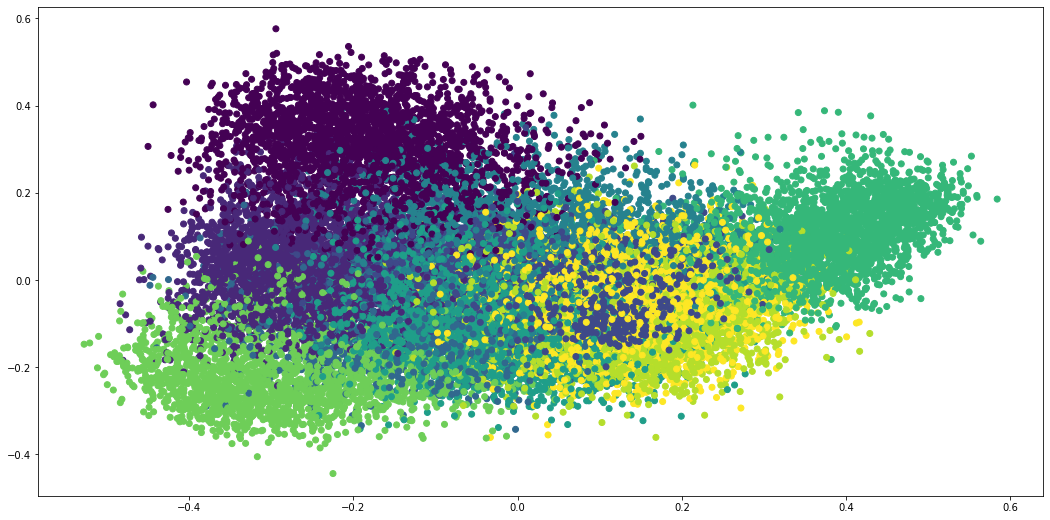

In [13]:
plt.figure(figsize=(18, 9))
plt.scatter(pca[:, 0], pca[:, 1], c=y);

### Clusters most common words: (second evaluation)

In [14]:
results = pd.DataFrame()
for label in range(10):
    results[f"Cluster{label}"] = df[y == label].Text_words.explode().value_counts().head(15).index
results

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9
0,ukraine,trump,tesla,covid,inflation,book,developer,abortion,learn,get
1,war,democrats,elon,vaccine,workers,joe,salary,pregnancy,reality,new
2,russia,joe,musk,get,back,like,remote,women,virtual,apple
3,iran,biden,twitter,booster,work,rogan,job,right,deep,us
4,us,say,model,people,get,get,ps,get,robots,use
5,russian,get,buy,dose,go,go,full,people,ai,back
6,say,would,spot,vaccines,people,one,location,state,use,macbook
7,biden,people,first,say,pay,time,kpa,say,new,game
8,politics,go,get,vaccinate,office,back,stack,baby,science,launch
9,putin,back,someone,free,us,make,new,us,like,time


### Grouping new queries into clusters:

In [15]:
queries = [
   "Microsoft is saying goodbye to internet explorer! The oldest browser.",
           
   "Studies have shown that over 50% of approximately 6.1 million pregnancies\
    in the US each year are unintended. While birth control pills were first approved\
    for use in the US more than 60 years ago, about one-third of US women who have tried\
    to get or fill prescriptions have reported difficulties doing so.",

   "While physical books have noticed a resurgence, and for a good reason,\
    they could be better for the mind and wellness, based on science, holding\
    eBooks are somewhat more practical and fare much better in terms of ease of\
    carrying. Physical books vs ebooks, which is better?. They are locating out by reading.",

   "Twitter has sued billionaire Elon Musk in an effort to force him to follow through\
    with his deal to buy the social media company.",
    
   "The FDA authorized Novavax's Covid vaccine, which uses an older technology,\
    not mRNA like the Pfizer and Moderna vaccines.",
    
   "This is a new flue, this is not covid, this is much more severe!!!",
    
   "The MacBook is very strong and durable, and a big reason behind this is the fact that\
    it is made from aluminum. One of the downsides to making a product out of aluminum is that\
    it is going to be more expensive to manufacture. Aluminum products like this take time and precision to make",
    
   "Apple is rumored to be targeting a 2025 launch for its self-driving vehicle.\
    The company is reportedly exploring how to disguise a near-final design of the\
    vehicle for testing on public roads as soon as next year.",
    
   "The Google engineer who thinks the company's AI has come to life.\
    AI ethicists warned Google not to impersonate humans",
    
   "Member states of the North Atlantic Treaty Organization (NATO) have\
    signed off on the accession protocols for Finland and Sweden, days after\
    Turkey lifted its veto against the historic Nordic expansion.",
    
   "keeps growing its reach and subscribers, it also keeps growing its median employee pay.\
    When compared to all of the top public U.S. media companies by market capitalization, Netflix\
    led its peers with the highest median employee compensation at $219,577 in 2020, up from $202,931 a year earlier.",
    
   "The latest news, opinion and analysis on Donald Trump, the 45th president of the United States.",
    
   "Elon Musk co-founded and leads Tesla, SpaceX, Neuralink and The Boring Company.\
    As the co-founder and CEO of Tesla, Elon leads all product design, engineering and\
    global manufacturing of the company's electric vehicles, battery products and solar energy products.",
    
   "A full stack developer is not an average developer with just front-end or back-end engineering capabilities.\
    Full stack engineering warrants skills in both front-end and back-end technologies, as well as a great\
    understanding of web architecture. They are multi-taskers who work on the front-end, back-end, server, database,\
    and Application Programming Interface (API); that is, full stack developers deal with the full stack of software.",
    
    "As the technology improves, augmented reality has lots of potential to impact medicine. Augmented reality may\
     find its way into the primary care clinic, operating room, emergency room, and dental office. Doctors could use\
     it, for example, to plan plastic surgeries and other complex operations.",
    
    "Times have changed. Biden is an outlier in the US for being a President who has lost two children,\
     but he has a son who is 52 and a daughter who is 41.",    
]

In [18]:
preprocessor = Preprocessor()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
cleaned_queries = [preprocessor.clean_query(q) for q in queries]

In [20]:
joined = [" ".join(q) for q in cleaned_queries]

In [21]:
model = SentenceTransformer('all-MiniLM-L6-v2')
query_embeddings = np.zeros((len(queries), 384))

for row, q in enumerate(joined):
    query_embeddings[row, :] = model.encode(q)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [44]:
qy = kmeans.predict(np.array(query_embeddings, dtype=np.float32))

In [51]:
for i, q in enumerate(queries):
    print()
    print("-" * 100)
    print(f"Query: {q}")
    print()
    print(f"Cluster: {qy[i]}")
    print(f"Key-words of this cluster:")
    for kw in results[f'Cluster{qy[i]}']:
        print(kw, end=" ")


----------------------------------------------------------------------------------------------------
Query: Microsoft is saying goodbye to internet explorer! The oldest browser.

Cluster: 9
Key-words of this cluster:
get new apple us use back macbook game launch time like go make one today 
----------------------------------------------------------------------------------------------------
Query: Studies have shown that over 50% of approximately 6.1 million pregnancies    in the US each year are unintended. While birth control pills were first approved    for use in the US more than 60 years ago, about one-third of US women who have tried    to get or fill prescriptions have reported difficulties doing so.

Cluster: 7
Key-words of this cluster:
abortion pregnancy women right get people state say baby us would want make pregnant go 
----------------------------------------------------------------------------------------------------
Query: While physical books have noticed a resurgence,